# Notebook for brain voxels clustering

In this notebook we try to investigate networks of voxels in the brain when processing natural language and their potential meaning.
To do so, two approaches were considered:
    - fonctional clustering
    - semantic clustering

In [2]:
import warnings
warnings.simplefilter(action='ignore')

import os
import gc
import glob
import itertools
from tqdm import tqdm
from itertools import combinations
from joblib import Parallel, delayed

import umap
import scipy
import hdbscan
import nistats
import numpy as np
import pandas as pd
from sklearn import manifold
from sklearn.decomposition import PCA, FastICA
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.cluster import AgglomerativeClustering, KMeans

%matplotlib inline
import matplotlib
import seaborn as sns
import matplotlib.cm as cmx
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import nibabel as nib
import nilearn
from nilearn.image import load_img, mean_img, index_img, threshold_img, math_img, smooth_img, new_img_like
from nilearn.input_data import NiftiMapsMasker, NiftiMasker, NiftiLabelsMasker, MultiNiftiMasker
from nistats.second_level_model import SecondLevelModel
from nistats.thresholding import map_threshold
from nilearn import plotting
from nilearn import datasets
from scipy.stats import norm
from nilearn.surface import vol_to_surf

import utils 
import reporting
from logger import Logger
from linguistics_info import load_surnames, load_syntactic_roi, load_language_roi

### Paths

In [3]:
language = 'english'
model_name = 'bert-base-cased_pre-7_1_post-0_norm-None'

In [4]:
PROJECT_PATH = f"/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/"
OUTPUT_PATH = f"/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/maps/{language}"
INPUT_PATH = f"/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/{language}"
FMRIDATA_PATH = f"/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/fMRI/{language}"
MASKER_PATH = f"/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/ROI_masks/global_masker_95%_{language}"
ALL_MASKS_PATH = f"/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/ROI_masks/"
SAVING_FOLDER = f"/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/clustering/{language}"
TMP_FOLDER = f"/home/ap259944/tmp"

### Maskers

In [5]:
logger = Logger(os.path.join(PROJECT_PATH, 'logs.txt'))

global_masker_50 = reporting.fetch_masker(f"{ALL_MASKS_PATH}/global_masker_{language}"
, language, FMRIDATA_PATH, INPUT_PATH, smoothing_fwhm=None, logger=logger)
global_masker_95 = reporting.fetch_masker(f"{ALL_MASKS_PATH}/global_masker_95%_{language}"
, language, FMRIDATA_PATH, INPUT_PATH, smoothing_fwhm=None, logger=logger)


original_masker = global_masker_50
new_masker = global_masker_95
original_masker.set_params(detrend=False, standardize=False)
new_masker.set_params(detrend=False, standardize=False)


NiftiMasker(detrend=False, dtype=None, high_pass=None, low_pass=None,
            mask_args=None,
            mask_img=<nibabel.nifti1.Nifti1Image object at 0x7efd1ad389d0>,
            mask_strategy='background', memory=Memory(location=None),
            memory_level=0, reports=True, sample_mask=None, sessions=None,
            smoothing_fwhm=None, standardize=False, t_r=None,
            target_affine=None, target_shape=None, verbose=0)

### Atlas

In [6]:
atlas_maps, labels = reporting.load_atlas() # load harvard-oxford atlas named'cort-prob-2mm'

### Additional parameters

In [7]:
params = {
        'reduction':'umap', 
        'clustering':'hdbscan', 
        'min_cluster_size':50, 
        'min_samples':10, 
        'n_neighbors':4, 
        'min_dist':0.0, 
        'n_components':7, 
        'n_clusters':13, 
        'random_state':1111, 
        'cluster_selection_epsilon':0.5, 
        'affinity_reduc' : 'nearest_neighbors',
        'affinity_cluster':'cosine', 
        'linkage':'average',
        'saving_folder': None,
        'plot_name': None
}

In [8]:
view = 'left' #left
kwargs = {
    'surf_mesh': f'pial_{view}', # pial_right, infl_left, infl_right
    'surf_mesh_type': f'pial_{view}',
    'hemi': view, # right
    'view':'lateral', # medial
    'bg_map': f'sulc_{view}', # sulc_right
    'bg_on_data':True,
    'darkness':.8,
    'axes':None, 
    'figure':None
}

### Subjects

In [9]:
subject_names_list = [utils.get_subject_name(sub_id) for sub_id in utils.possible_subjects_id(language)]
subject_ids_list = utils.possible_subjects_id(language)

# UMAP behave strangly when directly apply to the fMRI data of the following subjects, I don't know why. 
# But we still includ them in the study.

black_list_index = [10, 14, 16, 26, 31, 43]
clean_mask = np.ones(len(subject_names_list))
clean_mask[black_list_index] = 0
clean_mask = clean_mask.astype(bool)
clean_subjects = np.array(subject_names_list)[clean_mask]

In [10]:
path_to_data_template = "/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/maps/english/{subject_name}/bert-base-cased_pre-7_1_post-0_norm-None_norm-inf_temporal-shifting-0_{subject_id}_hidden-all-layers/{subject_name}_bert-base-cased_pre-7_1_post-0_norm-None_norm-inf_temporal-shifting-0_{subject_id}_hidden-all-layers_coef_.npy"
mask_template = "/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/maps/english/{subject_name}/bert-base-cased_pre-7_1_post-0_norm-None_norm-inf_temporal-shifting-0_{subject_id}_hidden-all-layers/{subject_name}_bert-base-cased_pre-7_1_post-0_norm-None_norm-inf_temporal-shifting-0_{subject_id}_hidden-all-layers_Pearson_coeff.nii.gz"

### Words data

In the following cell you can specify the words that you don't want to keep in the clustering analysis.

In [11]:
filtered_words = [
    'a', 
    's',
    'the', 
    'he', 
    'she', 
    'I', 
    'i', 
    'my', 
    'me', 
    '"', 
    ',', 
    '.', 
    '!', 
    'that', 
    'they',
    'this', 
    'them', 
    'and', 
    'you',
    'it',
    '“', 
    '”',
    '‘', 
    '’'
]

In [12]:
# Fetching words
onsets = [pd.read_csv(os.path.join(PROJECT_PATH, 'data', 'onsets-offsets', language, 'word+punctuation_run{index}.csv'.format(index=index))) for index in range(1, 10)]
onsets = [item['word'].values for item in onsets]
onsets = np.hstack(onsets)


In [13]:
# Fetching model activations
all_data = [pd.read_csv(os.path.join(INPUT_PATH, model_name, 'activations_run{index}.csv'.format(index=index))) for index in range(1, 10)]


In [14]:
data_array = [data_tmp.values[:, :768*13] for data_tmp in all_data] # only keep hidden states

# see LayerWiseAnalysis
aggregation_type = 'pca' # 'pca', 'layer', 'attention_head'
data_agg = reporting.aggregate_beta_maps(
    np.vstack(data_array),
    nb_layers=13, 
    layer_size=768, 
    aggregation_type=aggregation_type,
    n_components=100
)

In [13]:
# Filtering words
indexes = Parallel(n_jobs=-1)(delayed(reporting.extract_indexes)(onsets, item) for item in filtered_words) #returns a list of list of indexes
mask = np.ones(onsets.shape)
mask[np.hstack([item[0] for item in indexes])] = 0 #flatten 'indexes' object and put 0 at specified indexes values in the mask
mask = mask.astype(bool)

In [14]:
# Applying word mask
data_words_filtered = data_agg[mask, :] # dimension: #words * #features
onsets_filtered = onsets[mask]

In [17]:
standardize_words_activations = True

# standardize words activations if necessary
if standardize_words_activations:
    scaler = StandardScaler(with_mean=True, with_std=True)
    data_words_filtered = scaler.fit_transform(data_words_filtered.T).T

In [12]:
folder_words = os.path.join(SAVING_FOLDER, 'filtered_words_data', model_name)
utils.check_folder(folder_words)

In [13]:
data_words_filtered = np.load(os.path.join(folder_words, 'data_words_filtered.npy'))
onsets_filtered = np.load(os.path.join(folder_words, 'onsets_filtered.npy'), allow_pickle=True)


In [23]:
np.save(os.path.join(folder_words, 'data_words_filtered.npy'), data_words_filtered)
np.save(os.path.join(folder_words, 'onsets_filtered.npy'), onsets_filtered)


## Data preparation

In [11]:
all_data_voxels = []
all_masks = []
aggregation_type = 'pca' # 'pca', 'layer', 'attention_head'
n_components_beginning = 100

In [12]:
for index, subject_name in tqdm(enumerate(subject_names_list)):
    subject_id = subject_ids_list[index]
    path_to_beta_maps = path_to_data_template.format(model_name=model_name, subject_name=subject_name, subject_id=subject_id)
    mask = reporting.create_subject_mask(mask_template, subject_name, subject_id, model_name, global_masker_95, threshold=80)
    
    data = np.load(path_to_beta_maps)
    all_masks.append(mask)
    all_data_voxels.append(
        reporting.resample_beta_maps(
            reporting.aggregate_beta_maps(
                np.vstack(data) if mask is not None else data.copy(), 
                nb_layers=13, 
                layer_size=768, 
                aggregation_type=aggregation_type,
                n_components=n_components_beginning), 
            original_masker, 
            new_masker)[mask, :])
    #all_original_length.append(data.shape[0] if mask is not None else data.copy().shape[0])

0it [00:00, ?it/s]

Original data has dimension:  (26164, 100)


1it [00:28, 28.51s/it]

New data has dimension:  (22378, 100)
Original data has dimension:  (26164, 100)


2it [00:39, 23.23s/it]

New data has dimension:  (22378, 100)
Original data has dimension:  (26164, 100)


3it [00:50, 19.45s/it]

New data has dimension:  (22378, 100)
Original data has dimension:  (26164, 100)


4it [01:18, 22.08s/it]

New data has dimension:  (22378, 100)
Original data has dimension:  (26164, 100)


5it [01:30, 19.04s/it]

New data has dimension:  (22378, 100)
Original data has dimension:  (26164, 100)


6it [02:00, 22.33s/it]

New data has dimension:  (22378, 100)
Original data has dimension:  (26164, 100)


7it [02:29, 24.53s/it]

New data has dimension:  (22378, 100)
Original data has dimension:  (26164, 100)


8it [02:59, 26.00s/it]

New data has dimension:  (22378, 100)
Original data has dimension:  (26164, 100)


9it [03:28, 27.00s/it]

New data has dimension:  (22378, 100)
Original data has dimension:  (26164, 100)


10it [03:57, 27.66s/it]

New data has dimension:  (22378, 100)
Original data has dimension:  (26164, 100)


11it [04:30, 29.14s/it]

New data has dimension:  (22378, 100)
Original data has dimension:  (26164, 100)


12it [04:58, 28.92s/it]

New data has dimension:  (22378, 100)
Original data has dimension:  (26164, 100)


13it [05:27, 28.75s/it]

New data has dimension:  (22378, 100)
Original data has dimension:  (26164, 100)


14it [05:55, 28.56s/it]

New data has dimension:  (22378, 100)
Original data has dimension:  (26164, 100)


15it [06:23, 28.53s/it]

New data has dimension:  (22378, 100)
Original data has dimension:  (26164, 100)


16it [06:53, 28.91s/it]

New data has dimension:  (22378, 100)
Original data has dimension:  (26164, 100)


17it [07:23, 29.23s/it]

New data has dimension:  (22378, 100)
Original data has dimension:  (26164, 100)


18it [07:52, 29.22s/it]

New data has dimension:  (22378, 100)
Original data has dimension:  (26164, 100)


19it [08:21, 29.03s/it]

New data has dimension:  (22378, 100)
Original data has dimension:  (26164, 100)


20it [09:02, 32.75s/it]

New data has dimension:  (22378, 100)
Original data has dimension:  (26164, 100)


21it [09:25, 29.77s/it]

New data has dimension:  (22378, 100)
Original data has dimension:  (26164, 100)


22it [09:54, 29.52s/it]

New data has dimension:  (22378, 100)
Original data has dimension:  (26164, 100)


23it [10:12, 26.17s/it]

New data has dimension:  (22378, 100)
Original data has dimension:  (26164, 100)


24it [10:42, 27.07s/it]

New data has dimension:  (22378, 100)
Original data has dimension:  (26164, 100)


25it [11:11, 27.64s/it]

New data has dimension:  (22378, 100)
Original data has dimension:  (26164, 100)


26it [11:40, 28.19s/it]

New data has dimension:  (22378, 100)
Original data has dimension:  (26164, 100)


27it [12:14, 29.89s/it]

New data has dimension:  (22378, 100)
Original data has dimension:  (26164, 100)


28it [12:44, 30.03s/it]

New data has dimension:  (22378, 100)
Original data has dimension:  (26164, 100)


29it [13:14, 29.94s/it]

New data has dimension:  (22378, 100)
Original data has dimension:  (26164, 100)


30it [13:43, 29.72s/it]

New data has dimension:  (22378, 100)
Original data has dimension:  (26164, 100)


31it [14:14, 30.03s/it]

New data has dimension:  (22378, 100)
Original data has dimension:  (26164, 100)


32it [14:44, 30.10s/it]

New data has dimension:  (22378, 100)
Original data has dimension:  (26164, 100)


33it [15:13, 29.83s/it]

New data has dimension:  (22378, 100)
Original data has dimension:  (26164, 100)


34it [15:42, 29.54s/it]

New data has dimension:  (22378, 100)
Original data has dimension:  (26164, 100)


35it [16:11, 29.38s/it]

New data has dimension:  (22378, 100)
Original data has dimension:  (26164, 100)


36it [16:41, 29.58s/it]

New data has dimension:  (22378, 100)
Original data has dimension:  (26164, 100)


37it [17:13, 30.23s/it]

New data has dimension:  (22378, 100)
Original data has dimension:  (26164, 100)


38it [17:45, 30.68s/it]

New data has dimension:  (22378, 100)
Original data has dimension:  (26164, 100)


39it [18:25, 33.42s/it]

New data has dimension:  (22378, 100)
Original data has dimension:  (26164, 100)


40it [18:57, 33.07s/it]

New data has dimension:  (22378, 100)
Original data has dimension:  (26164, 100)


41it [19:31, 33.26s/it]

New data has dimension:  (22378, 100)
Original data has dimension:  (26164, 100)


42it [20:06, 33.77s/it]

New data has dimension:  (22378, 100)
Original data has dimension:  (26164, 100)


43it [20:40, 34.10s/it]

New data has dimension:  (22378, 100)
Original data has dimension:  (26164, 100)


44it [21:20, 35.80s/it]

New data has dimension:  (22378, 100)
Original data has dimension:  (26164, 100)


45it [22:04, 38.22s/it]

New data has dimension:  (22378, 100)
Original data has dimension:  (26164, 100)


46it [22:42, 38.04s/it]

New data has dimension:  (22378, 100)
Original data has dimension:  (26164, 100)


47it [23:23, 38.97s/it]

New data has dimension:  (22378, 100)
Original data has dimension:  (26164, 100)


48it [24:06, 40.24s/it]

New data has dimension:  (22378, 100)
Original data has dimension:  (26164, 100)


49it [24:53, 42.25s/it]

New data has dimension:  (22378, 100)
Original data has dimension:  (26164, 100)


50it [25:40, 43.85s/it]

New data has dimension:  (22378, 100)
Original data has dimension:  (26164, 100)


51it [26:30, 31.18s/it]

New data has dimension:  (22378, 100)


In [14]:
folder = os.path.join(SAVING_FOLDER, 'filter_80_fmri_data', model_name)
utils.check_folder(folder)
np.save(os.path.join(folder, 'all_masks_attention_head.npy'), np.array(all_masks))
np.save(os.path.join(folder, 'all_data_attention_head.npy'), np.array(all_data_voxels))
#all_masks = np.load(os.path.join(folder, 'all_masks_attention_head.npy'))
#all_data_voxels = np.load(os.path.join(folder, 'all_data_attention_head.npy'))

In [16]:
average_mask = math_img('img>0.4', img=mean_img(new_masker.inverse_transform(all_masks))) # take the average mask and threshold at 0.5


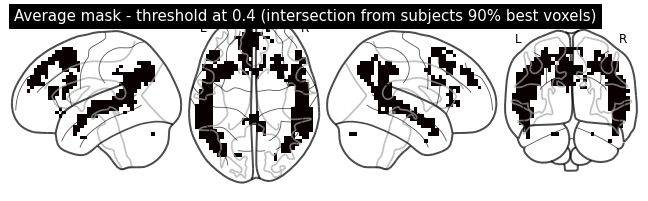

In [17]:
plotting.plot_glass_brain(average_mask, colorbar=False, display_mode = 'lzry', title='Average mask - threshold at 0.4 (intersection from subjects 90% best voxels)')
plotting.show()

In [18]:
voxels_data = np.vstack(all_data_voxels)

In [19]:
standardize_beta_maps = True

# standardize beta maps if necessary
if standardize_beta_maps:
    scaler = StandardScaler(with_mean=True, with_std=True)
    voxels_data = scaler.fit_transform(voxels_data.T).T

## Fonctional clustering

We cluster voxels based on their dependencies towards model features.
Voxels with similar dpeendency patterns are likely to deal with similar information.
To do so, we regroup in one big matrix all subjects voxels as to learn shared clustering patterns.

In [20]:
nb_voxels=int(all_masks.shape[1])
nb_voxels

22378

In [26]:
reporting.plot_functional_clustering(
    data=voxels_data, 
    mask=np.hstack(all_masks),
    masker=new_masker,
    average_mask=average_mask,
    nb_voxels=nb_voxels,
    nb_subjects=len(subject_names_list),
    data_name='{}_{}-{}'.format(model_name, aggregation_type, n_components_beginning),
    params=params,
    saving_folder=SAVING_FOLDER,
    n_neighbors_list=[4, 5],
    min_samples_list=[5, 8, 10, 12, 15, 17, 20, 23,  25, 27, 30],
    min_cluster_size_list=[200, 300, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000, 1100, 1200, 1300, 1350 ,1400, 1450, 1500, 1550, 1600, 1700, 1750, 1800, 1850, 1900],
    tmp_folder=TMP_FOLDER, 
    return_plot=False,
    **kwargs
    )

Reducing...
Input shape:  (1141278,)
Number of clusters:  167
Number of voxels: 22378
Effective number of clusters: 166
Input shape:  (1141278,)
Number of clusters:  93
Number of voxels: 22378
Effective number of clusters: 92
Input shape:  (1141278,)
Number of clusters:  3
Number of voxels: 22378
Effective number of clusters: 2
Input shape:  (1141278,)
Number of clusters:  17
Number of voxels: 22378
Effective number of clusters: 16
Input shape:  (1141278,)
Number of clusters:  16
Number of voxels: 22378
Effective number of clusters: 15
Input shape:  (1141278,)
Number of clusters:  13
Number of voxels: 22378
Effective number of clusters: 12
Input shape:  (1141278,)
Number of clusters:  12
Number of voxels: 22378
Effective number of clusters: 11
Input shape:  (1141278,)
Number of clusters:  12
Number of voxels: 22378
Effective number of clusters: 11
Input shape:  (1141278,)
Number of clusters:  11
Number of voxels: 22378
Effective number of clusters: 10
Input shape:  (1141278,)
Number of

Input shape:  (1141278,)
Number of clusters:  4
Number of voxels: 22378
Effective number of clusters: 3
Input shape:  (1141278,)
Number of clusters:  4
Number of voxels: 22378
Effective number of clusters: 3
Input shape:  (1141278,)
Number of clusters:  153
Number of voxels: 22378
Effective number of clusters: 152
Input shape:  (1141278,)
Number of clusters:  83
Number of voxels: 22378
Effective number of clusters: 82
Input shape:  (1141278,)
Number of clusters:  4
Number of voxels: 22378
Effective number of clusters: 3
Input shape:  (1141278,)
Number of clusters:  4
Number of voxels: 22378
Effective number of clusters: 3
Input shape:  (1141278,)
Number of clusters:  3
Number of voxels: 22378
Effective number of clusters: 2
Input shape:  (1141278,)
Number of clusters:  19
Number of voxels: 22378
Effective number of clusters: 18
Input shape:  (1141278,)
Number of clusters:  18
Number of voxels: 22378
Effective number of clusters: 17
Input shape:  (1141278,)
Number of clusters:  4
Number

Input shape:  (1141278,)
Number of clusters:  3
Number of voxels: 22378
Effective number of clusters: 2
Input shape:  (1141278,)
Number of clusters:  3
Number of voxels: 22378
Effective number of clusters: 2
Input shape:  (1141278,)
Number of clusters:  3
Number of voxels: 22378
Effective number of clusters: 2
Input shape:  (1141278,)
Number of clusters:  3
Number of voxels: 22378
Effective number of clusters: 2
Input shape:  (1141278,)
Number of clusters:  152
Number of voxels: 22378
Effective number of clusters: 151
Input shape:  (1141278,)
Number of clusters:  75
Number of voxels: 22378
Effective number of clusters: 74
Input shape:  (1141278,)
Number of clusters:  3
Number of voxels: 22378
Effective number of clusters: 2
Input shape:  (1141278,)
Number of clusters:  3
Number of voxels: 22378
Effective number of clusters: 2
Input shape:  (1141278,)
Number of clusters:  4
Number of voxels: 22378
Effective number of clusters: 3
Input shape:  (1141278,)
Number of clusters:  4
Number of 

Input shape:  (1141278,)
Number of clusters:  3
Number of voxels: 22378
Effective number of clusters: 2
Input shape:  (1141278,)
Number of clusters:  3
Number of voxels: 22378
Effective number of clusters: 2
Input shape:  (1141278,)
Number of clusters:  3
Number of voxels: 22378
Effective number of clusters: 2
Input shape:  (1141278,)
Number of clusters:  3
Number of voxels: 22378
Effective number of clusters: 2
Input shape:  (1141278,)
Number of clusters:  3
Number of voxels: 22378
Effective number of clusters: 2
Input shape:  (1141278,)
Number of clusters:  3
Number of voxels: 22378
Effective number of clusters: 2
Input shape:  (1141278,)
Number of clusters:  140
Number of voxels: 22378
Effective number of clusters: 139
Input shape:  (1141278,)
Number of clusters:  63
Number of voxels: 22378
Effective number of clusters: 62
Input shape:  (1141278,)
Number of clusters:  3
Number of voxels: 22378
Effective number of clusters: 2
Input shape:  (1141278,)
Number of clusters:  3
Number of 

Input shape:  (1141278,)
Number of clusters:  4
Number of voxels: 22378
Effective number of clusters: 3
Input shape:  (1141278,)
Number of clusters:  4
Number of voxels: 22378
Effective number of clusters: 3
Input shape:  (1141278,)
Number of clusters:  4
Number of voxels: 22378
Effective number of clusters: 3
Input shape:  (1141278,)
Number of clusters:  3
Number of voxels: 22378
Effective number of clusters: 2
Input shape:  (1141278,)
Number of clusters:  3
Number of voxels: 22378
Effective number of clusters: 2
Input shape:  (1141278,)
Number of clusters:  3
Number of voxels: 22378
Effective number of clusters: 2
Input shape:  (1141278,)
Number of clusters:  3
Number of voxels: 22378
Effective number of clusters: 2
Input shape:  (1141278,)
Number of clusters:  3
Number of voxels: 22378
Effective number of clusters: 2
Input shape:  (1141278,)
Number of clusters:  177
Number of voxels: 22378
Effective number of clusters: 176
Input shape:  (1141278,)
Number of clusters:  100
Number of 

Input shape:  (1141278,)
Number of clusters:  6
Number of voxels: 22378
Effective number of clusters: 5
Input shape:  (1141278,)
Number of clusters:  6
Number of voxels: 22378
Effective number of clusters: 5
Input shape:  (1141278,)
Number of clusters:  5
Number of voxels: 22378
Effective number of clusters: 4
Input shape:  (1141278,)
Number of clusters:  4
Number of voxels: 22378
Effective number of clusters: 3
Input shape:  (1141278,)
Number of clusters:  4
Number of voxels: 22378
Effective number of clusters: 3
Input shape:  (1141278,)
Number of clusters:  3
Number of voxels: 22378
Effective number of clusters: 2
Input shape:  (1141278,)
Number of clusters:  3
Number of voxels: 22378
Effective number of clusters: 2
Input shape:  (1141278,)
Number of clusters:  3
Number of voxels: 22378
Effective number of clusters: 2
Input shape:  (1141278,)
Number of clusters:  3
Number of voxels: 22378
Effective number of clusters: 2
Input shape:  (1141278,)
Number of clusters:  3
Number of voxels

Input shape:  (1141278,)
Number of clusters:  6
Number of voxels: 22378
Effective number of clusters: 5
Input shape:  (1141278,)
Number of clusters:  5
Number of voxels: 22378
Effective number of clusters: 4
Input shape:  (1141278,)
Number of clusters:  5
Number of voxels: 22378
Effective number of clusters: 4
Input shape:  (1141278,)
Number of clusters:  5
Number of voxels: 22378
Effective number of clusters: 4
Input shape:  (1141278,)
Number of clusters:  5
Number of voxels: 22378
Effective number of clusters: 4
Input shape:  (1141278,)
Number of clusters:  4
Number of voxels: 22378
Effective number of clusters: 3
Input shape:  (1141278,)
Number of clusters:  4
Number of voxels: 22378
Effective number of clusters: 3
Input shape:  (1141278,)
Number of clusters:  4
Number of voxels: 22378
Effective number of clusters: 3
Input shape:  (1141278,)
Number of clusters:  4
Number of voxels: 22378
Effective number of clusters: 3
Input shape:  (1141278,)
Number of clusters:  3
Number of voxels

Input shape:  (1141278,)
Number of clusters:  6
Number of voxels: 22378
Effective number of clusters: 5
Input shape:  (1141278,)
Number of clusters:  6
Number of voxels: 22378
Effective number of clusters: 5
Input shape:  (1141278,)
Number of clusters:  5
Number of voxels: 22378
Effective number of clusters: 4
Input shape:  (1141278,)
Number of clusters:  5
Number of voxels: 22378
Effective number of clusters: 4
Input shape:  (1141278,)
Number of clusters:  5
Number of voxels: 22378
Effective number of clusters: 4
Input shape:  (1141278,)
Number of clusters:  5
Number of voxels: 22378
Effective number of clusters: 4
Input shape:  (1141278,)
Number of clusters:  5
Number of voxels: 22378
Effective number of clusters: 4
Input shape:  (1141278,)
Number of clusters:  3
Number of voxels: 22378
Effective number of clusters: 2
Input shape:  (1141278,)
Number of clusters:  3
Number of voxels: 22378
Effective number of clusters: 2
Input shape:  (1141278,)
Number of clusters:  3
Number of voxels

Have a loook at 'SAVING_FOLDER' were all figures are displayed.

Interesting plots:

In [27]:
paths = [
 '/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/clustering/data-average_umap_hdbscan/labels/all-subjects_red-umap_clust-hdbscan_min-c-size-1250_n-neigh-5_n-comp-3_aff-clus-euclidean_link-ward_min-samples-3_metric-r-cosine_metric-c-euclidean_out-metric-euclidean_nb_clusters-23.npy',
 '/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/clustering/data-average_umap_hdbscan/labels/all-subjects_red-umap_clust-hdbscan_min-c-size-1450_n-neigh-4_n-comp-3_aff-clus-euclidean_link-ward_min-samples-10_metric-r-cosine_metric-c-euclidean_out-metric-euclidean_nb_clusters-15.npy',
 '/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/clustering/data-average_umap_hdbscan/labels/all-subjects_red-umap_clust-hdbscan_min-c-size-1500_n-neigh-4_n-comp-3_aff-clus-euclidean_link-ward_min-samples-10_metric-r-cosine_metric-c-euclidean_out-metric-euclidean_nb_clusters-15.npy',
 '/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/clustering/data-average_umap_hdbscan/labels/all-subjects_red-umap_clust-hdbscan_min-c-size-1550_n-neigh-4_n-comp-3_aff-clus-euclidean_link-ward_min-samples-10_metric-r-cosine_metric-c-euclidean_out-metric-euclidean_nb_clusters-15.npy',
 '/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/clustering/data-pca_umap_hdbscan/labels/all-subjects_red-umap_clust-hdbscan_min-c-size-1450_n-neigh-4_n-comp-3_aff-clus-euclidean_link-ward_min-samples-5_metric-r-cosine_metric-c-euclidean_out-metric-euclidean_nb_clusters-19.npy',
 '/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/clustering/data-pca_umap_hdbscan/labels/all-subjects_red-umap_clust-hdbscan_min-c-size-1500_n-neigh-4_n-comp-3_aff-clus-euclidean_link-ward_min-samples-5_metric-r-cosine_metric-c-euclidean_out-metric-euclidean_nb_clusters-19.npy',
 '/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/clustering/data-pca_umap_hdbscan/labels/all-subjects_red-umap_clust-hdbscan_min-c-size-1550_n-neigh-4_n-comp-3_aff-clus-euclidean_link-ward_min-samples-5_metric-r-cosine_metric-c-euclidean_out-metric-euclidean_nb_clusters-17.npy',
 '/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/clustering/bert-base-cased_pre-7_1_post-0_norm-None_norm-inf/data-attention_head_umap_hdbscan/labels/all-subjects_red-umap_clust-hdbscan_min-c-size-1350_n-neigh-3_n-comp-3_aff-clus-cosine_link-average_min-samples-30_metric-r-cosine_metric-c-euclidean_out-metric-euclidean_nb_clusters-26.npy',
 '/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/clustering/bert-base-cased_pre-7_1_post-0_norm-None_norm-inf/data-attention_head_umap_hdbscan/labels/all-subjects_red-umap_clust-hdbscan_min-c-size-1400_n-neigh-3_n-comp-3_aff-clus-cosine_link-average_min-samples-20_metric-r-cosine_metric-c-euclidean_out-metric-euclidean_nb_clusters-26.npy',
 '/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/clustering/bert-base-cased_pre-7_1_post-0_norm-None_norm-inf/data-attention_head_umap_hdbscan/labels/all-subjects_red-umap_clust-hdbscan_min-c-size-1400_n-neigh-3_n-comp-3_aff-clus-cosine_link-average_min-samples-23_metric-r-cosine_metric-c-euclidean_out-metric-euclidean_nb_clusters-24.npy',
 '/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/clustering/bert-base-cased_pre-7_1_post-0_norm-None_norm-inf/data-attention_head_umap_hdbscan/labels/all-subjects_red-umap_clust-hdbscan_min-c-size-1400_n-neigh-3_n-comp-3_aff-clus-cosine_link-average_min-samples-25_metric-r-cosine_metric-c-euclidean_out-metric-euclidean_nb_clusters-22.npy',
 '/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/clustering/bert-base-cased_pre-7_1_post-0_norm-None_norm-inf/data-attention_head_umap_hdbscan/labels/all-subjects_red-umap_clust-hdbscan_min-c-size-1400_n-neigh-3_n-comp-3_aff-clus-cosine_link-average_min-samples-27_metric-r-cosine_metric-c-euclidean_out-metric-euclidean_nb_clusters-29.npy',
 '/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/clustering/bert-base-cased_pre-7_1_post-0_norm-None_norm-inf/data-attention_head_umap_hdbscan/labels/all-subjects_red-umap_clust-hdbscan_min-c-size-1450_n-neigh-3_n-comp-3_aff-clus-cosine_link-average_min-samples-15_metric-r-cosine_metric-c-euclidean_out-metric-euclidean_nb_clusters-29.npy',
 '/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/clustering/bert-base-cased_pre-7_1_post-0_norm-None_norm-inf/data-attention_head_umap_hdbscan/labels/all-subjects_red-umap_clust-hdbscan_min-c-size-1450_n-neigh-3_n-comp-3_aff-clus-cosine_link-average_min-samples-17_metric-r-cosine_metric-c-euclidean_out-metric-euclidean_nb_clusters-27.npy',
 '/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/clustering/bert-base-cased_pre-7_1_post-0_norm-None_norm-inf/data-attention_head_umap_hdbscan/labels/all-subjects_red-umap_clust-hdbscan_min-c-size-1450_n-neigh-3_n-comp-3_aff-clus-cosine_link-average_min-samples-20_metric-r-cosine_metric-c-euclidean_out-metric-euclidean_nb_clusters-24.npy',
 '/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/clustering/bert-base-cased_pre-7_1_post-0_norm-None_norm-inf/data-attention_head_umap_hdbscan/labels/all-subjects_red-umap_clust-hdbscan_min-c-size-1450_n-neigh-3_n-comp-3_aff-clus-cosine_link-average_min-samples-25_metric-r-cosine_metric-c-euclidean_out-metric-euclidean_nb_clusters-19.npy',
 '/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/clustering/bert-base-cased_pre-7_1_post-0_norm-None_norm-inf/data-attention_head_umap_hdbscan/labels/all-subjects_red-umap_clust-hdbscan_min-c-size-1450_n-neigh-3_n-comp-3_aff-clus-cosine_link-average_min-samples-27_metric-r-cosine_metric-c-euclidean_out-metric-euclidean_nb_clusters-28.npy',
 '/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/clustering/bert-base-cased_pre-7_1_post-0_norm-None_norm-inf/data-attention_head_umap_hdbscan/labels/all-subjects_red-umap_clust-hdbscan_min-c-size-1500_n-neigh-3_n-comp-3_aff-clus-cosine_link-average_min-samples-17_metric-r-cosine_metric-c-euclidean_out-metric-euclidean_nb_clusters-25.npy',
 '/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/clustering/bert-base-cased_pre-7_1_post-0_norm-None_norm-inf/data-attention_head_umap_hdbscan/labels/all-subjects_red-umap_clust-hdbscan_min-c-size-1500_n-neigh-3_n-comp-3_aff-clus-cosine_link-average_min-samples-20_metric-r-cosine_metric-c-euclidean_out-metric-euclidean_nb_clusters-23.npy',
 '/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/clustering/bert-base-cased_pre-7_1_post-0_norm-None_norm-inf/data-attention_head_umap_hdbscan/labels/all-subjects_red-umap_clust-hdbscan_min-c-size-1500_n-neigh-3_n-comp-3_aff-clus-cosine_link-average_min-samples-25_metric-r-cosine_metric-c-euclidean_out-metric-euclidean_nb_clusters-19.npy',
 '/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/clustering/bert-base-cased_pre-7_1_post-0_norm-None_norm-inf/data-attention_head_umap_hdbscan/labels/all-subjects_red-umap_clust-hdbscan_min-c-size-1500_n-neigh-3_n-comp-3_aff-clus-cosine_link-average_min-samples-27_metric-r-cosine_metric-c-euclidean_out-metric-euclidean_nb_clusters-25.npy',
 '/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/clustering/bert-base-cased_pre-7_1_post-0_norm-None_norm-inf/data-attention_head_umap_hdbscan/labels/all-subjects_red-umap_clust-hdbscan_min-c-size-1500_n-neigh-3_n-comp-3_aff-clus-cosine_link-average_min-samples-30_metric-r-cosine_metric-c-euclidean_out-metric-euclidean_nb_clusters-23.npy',
 '/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/clustering/bert-base-cased_pre-7_1_post-0_norm-None_norm-inf/data-attention_head_umap_hdbscan/labels/all-subjects_red-umap_clust-hdbscan_min-c-size-1550_n-neigh-3_n-comp-3_aff-clus-cosine_link-average_min-samples-17_metric-r-cosine_metric-c-euclidean_out-metric-euclidean_nb_clusters-24.npy',
 '/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/clustering/bert-base-cased_pre-7_1_post-0_norm-None_norm-inf/data-attention_head_umap_hdbscan/labels/all-subjects_red-umap_clust-hdbscan_min-c-size-1550_n-neigh-3_n-comp-3_aff-clus-cosine_link-average_min-samples-20_metric-r-cosine_metric-c-euclidean_out-metric-euclidean_nb_clusters-22.npy',
 '/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/clustering/bert-base-cased_pre-7_1_post-0_norm-None_norm-inf/data-attention_head_umap_hdbscan/labels/all-subjects_red-umap_clust-hdbscan_min-c-size-1550_n-neigh-3_n-comp-3_aff-clus-cosine_link-average_min-samples-25_metric-r-cosine_metric-c-euclidean_out-metric-euclidean_nb_clusters-19.npy',
 '/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/clustering/bert-base-cased_pre-7_1_post-0_norm-None_norm-inf/data-attention_head_umap_hdbscan/labels/all-subjects_red-umap_clust-hdbscan_min-c-size-1550_n-neigh-3_n-comp-3_aff-clus-cosine_link-average_min-samples-27_metric-r-cosine_metric-c-euclidean_out-metric-euclidean_nb_clusters-25.npy',
 '/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/clustering/bert-base-cased_pre-7_1_post-0_norm-None_norm-inf/data-attention_head_umap_hdbscan/labels/all-subjects_red-umap_clust-hdbscan_min-c-size-1550_n-neigh-3_n-comp-3_aff-clus-cosine_link-average_min-samples-30_metric-r-cosine_metric-c-euclidean_out-metric-euclidean_nb_clusters-23.npy',
 '/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/clustering/bert-base-cased_pre-7_1_post-0_norm-None_norm-inf/data-attention_head_umap_hdbscan/labels/all-subjects_red-umap_clust-hdbscan_min-c-size-1600_n-neigh-3_n-comp-3_aff-clus-cosine_link-average_min-samples-20_metric-r-cosine_metric-c-euclidean_out-metric-euclidean_nb_clusters-21.npy',
 '/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/clustering/bert-base-cased_pre-7_1_post-0_norm-None_norm-inf/data-attention_head_umap_hdbscan/labels/all-subjects_red-umap_clust-hdbscan_min-c-size-1600_n-neigh-3_n-comp-3_aff-clus-cosine_link-average_min-samples-25_metric-r-cosine_metric-c-euclidean_out-metric-euclidean_nb_clusters-18.npy',
 '/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/clustering/bert-base-cased_pre-7_1_post-0_norm-None_norm-inf/data-attention_head_umap_hdbscan/labels/all-subjects_red-umap_clust-hdbscan_min-c-size-1600_n-neigh-3_n-comp-3_aff-clus-cosine_link-average_min-samples-27_metric-r-cosine_metric-c-euclidean_out-metric-euclidean_nb_clusters-22.npy',
 '/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/clustering/bert-base-cased_pre-7_1_post-0_norm-None_norm-inf/data-attention_head_umap_hdbscan/labels/all-subjects_red-umap_clust-hdbscan_min-c-size-1600_n-neigh-3_n-comp-3_aff-clus-cosine_link-average_min-samples-30_metric-r-cosine_metric-c-euclidean_out-metric-euclidean_nb_clusters-22.npy',
 '/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/clustering/bert-base-cased_pre-7_1_post-0_norm-None_norm-inf/data-attention_head_umap_hdbscan/labels/all-subjects_red-umap_clust-hdbscan_min-c-size-1700_n-neigh-3_n-comp-3_aff-clus-cosine_link-average_min-samples-20_metric-r-cosine_metric-c-euclidean_out-metric-euclidean_nb_clusters-16.npy',
 '/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/clustering/bert-base-cased_pre-7_1_post-0_norm-None_norm-inf/data-attention_head_umap_hdbscan/labels/all-subjects_red-umap_clust-hdbscan_min-c-size-1700_n-neigh-3_n-comp-3_aff-clus-cosine_link-average_min-samples-25_metric-r-cosine_metric-c-euclidean_out-metric-euclidean_nb_clusters-16.npy',
 '/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/clustering/bert-base-cased_pre-7_1_post-0_norm-None_norm-inf/data-attention_head_umap_hdbscan/labels/all-subjects_red-umap_clust-hdbscan_min-c-size-1700_n-neigh-3_n-comp-3_aff-clus-cosine_link-average_min-samples-27_metric-r-cosine_metric-c-euclidean_out-metric-euclidean_nb_clusters-20.npy',
 '/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/clustering/bert-base-cased_pre-7_1_post-0_norm-None_norm-inf/data-attention_head_umap_hdbscan/labels/all-subjects_red-umap_clust-hdbscan_min-c-size-1700_n-neigh-3_n-comp-3_aff-clus-cosine_link-average_min-samples-30_metric-r-cosine_metric-c-euclidean_out-metric-euclidean_nb_clusters-20.npy',
 '/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/clustering/bert-base-cased_pre-7_1_post-0_norm-None_norm-inf/data-attention_head_umap_hdbscan/labels/all-subjects_red-umap_clust-hdbscan_min-c-size-1750_n-neigh-3_n-comp-3_aff-clus-cosine_link-average_min-samples-25_metric-r-cosine_metric-c-euclidean_out-metric-euclidean_nb_clusters-16.npy',
 '/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/clustering/bert-base-cased_pre-7_1_post-0_norm-None_norm-inf/data-attention_head_umap_hdbscan/labels/all-subjects_red-umap_clust-hdbscan_min-c-size-1750_n-neigh-3_n-comp-3_aff-clus-cosine_link-average_min-samples-27_metric-r-cosine_metric-c-euclidean_out-metric-euclidean_nb_clusters-20.npy',
 '/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/clustering/bert-base-cased_pre-7_1_post-0_norm-None_norm-inf/data-attention_head_umap_hdbscan/labels/all-subjects_red-umap_clust-hdbscan_min-c-size-1750_n-neigh-3_n-comp-3_aff-clus-cosine_link-average_min-samples-30_metric-r-cosine_metric-c-euclidean_out-metric-euclidean_nb_clusters-20.npy',
 '/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/clustering/bert-base-cased_pre-7_1_post-0_norm-None_norm-inf/data-attention_head_umap_hdbscan/labels/all-subjects_red-umap_clust-hdbscan_min-c-size-1800_n-neigh-3_n-comp-3_aff-clus-cosine_link-average_min-samples-25_metric-r-cosine_metric-c-euclidean_out-metric-euclidean_nb_clusters-16.npy',
 '/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/clustering/bert-base-cased_pre-7_1_post-0_norm-None_norm-inf/data-attention_head_umap_hdbscan/labels/all-subjects_red-umap_clust-hdbscan_min-c-size-1800_n-neigh-3_n-comp-3_aff-clus-cosine_link-average_min-samples-27_metric-r-cosine_metric-c-euclidean_out-metric-euclidean_nb_clusters-19.npy',
 '/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/clustering/bert-base-cased_pre-7_1_post-0_norm-None_norm-inf/data-attention_head_umap_hdbscan/labels/all-subjects_red-umap_clust-hdbscan_min-c-size-1800_n-neigh-3_n-comp-3_aff-clus-cosine_link-average_min-samples-30_metric-r-cosine_metric-c-euclidean_out-metric-euclidean_nb_clusters-18.npy',
 '/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/clustering/bert-base-cased_pre-7_1_post-0_norm-None_norm-inf/data-attention_head_umap_hdbscan/labels/all-subjects_red-umap_clust-hdbscan_min-c-size-1850_n-neigh-3_n-comp-3_aff-clus-cosine_link-average_min-samples-25_metric-r-cosine_metric-c-euclidean_out-metric-euclidean_nb_clusters-15.npy',
 '/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/clustering/bert-base-cased_pre-7_1_post-0_norm-None_norm-inf/data-attention_head_umap_hdbscan/labels/all-subjects_red-umap_clust-hdbscan_min-c-size-1850_n-neigh-3_n-comp-3_aff-clus-cosine_link-average_min-samples-27_metric-r-cosine_metric-c-euclidean_out-metric-euclidean_nb_clusters-17.npy',
 '/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/clustering/bert-base-cased_pre-7_1_post-0_norm-None_norm-inf/data-attention_head_umap_hdbscan/labels/all-subjects_red-umap_clust-hdbscan_min-c-size-1850_n-neigh-3_n-comp-3_aff-clus-cosine_link-average_min-samples-30_metric-r-cosine_metric-c-euclidean_out-metric-euclidean_nb_clusters-17.npy',
 '/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/clustering/bert-base-cased_pre-7_1_post-0_norm-None_norm-inf/data-attention_head_umap_hdbscan/labels/all-subjects_red-umap_clust-hdbscan_min-c-size-1900_n-neigh-3_n-comp-3_aff-clus-cosine_link-average_min-samples-27_metric-r-cosine_metric-c-euclidean_out-metric-euclidean_nb_clusters-17.npy',
 '/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/clustering/bert-base-cased_pre-7_1_post-0_norm-None_norm-inf/data-attention_head_umap_hdbscan/labels/all-subjects_red-umap_clust-hdbscan_min-c-size-1900_n-neigh-3_n-comp-3_aff-clus-cosine_link-average_min-samples-30_metric-r-cosine_metric-c-euclidean_out-metric-euclidean_nb_clusters-17.npy',
 '/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/clustering/bert-base-cased_pre-7_1_post-0_norm-None_norm-inf/data-attention_head_umap_hdbscan/labels/all-subjects_red-umap_clust-hdbscan_min-c-size-1850_n-neigh-3_n-comp-3_aff-clus-cosine_link-average_min-samples-25_metric-r-cosine_metric-c-euclidean_out-metric-euclidean_nb_clusters-15.npy',
 '/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/clustering/bert-base-cased_pre-7_1_post-0_norm-None_norm-inf/data-attention_head_umap_hdbscan/labels/all-subjects_red-umap_clust-hdbscan_min-c-size-1900_n-neigh-3_n-comp-3_aff-clus-cosine_link-average_min-samples-25_metric-r-cosine_metric-c-euclidean_out-metric-euclidean_nb_clusters-13.npy',
 '/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/clustering/bert-base-cased_pre-7_1_post-0_norm-None_norm-inf/data-attention_head_umap_hdbscan/labels/all-subjects_red-umap_clust-hdbscan_min-c-size-1850_n-neigh-5_n-comp-3_aff-clus-cosine_link-average_min-samples-25_metric-r-cosine_metric-c-euclidean_out-metric-euclidean_nb_clusters-44.npy',
 '/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/clustering/bert-base-cased_pre-7_1_post-0_norm-None_norm-inf/data-attention_head_umap_hdbscan/labels/all-subjects_red-umap_clust-hdbscan_min-c-size-1850_n-neigh-5_n-comp-3_aff-clus-cosine_link-average_min-samples-27_metric-r-cosine_metric-c-euclidean_out-metric-euclidean_nb_clusters-44.npy',
 '/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/clustering/bert-base-cased_pre-7_1_post-0_norm-None_norm-inf/data-attention_head_umap_hdbscan/labels/all-subjects_red-umap_clust-hdbscan_min-c-size-1870_n-neigh-5_n-comp-3_aff-clus-cosine_link-average_min-samples-20_metric-r-cosine_metric-c-euclidean_out-metric-euclidean_nb_clusters-44.npy',
 '/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/clustering/bert-base-cased_pre-7_1_post-0_norm-None_norm-inf/data-attention_head_umap_hdbscan/labels/all-subjects_red-umap_clust-hdbscan_min-c-size-1870_n-neigh-5_n-comp-3_aff-clus-cosine_link-average_min-samples-23_metric-r-cosine_metric-c-euclidean_out-metric-euclidean_nb_clusters-45.npy',
 '/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/clustering/bert-base-cased_pre-7_1_post-0_norm-None_norm-inf/data-attention_head_umap_hdbscan/labels/all-subjects_red-umap_clust-hdbscan_min-c-size-1870_n-neigh-5_n-comp-3_aff-clus-cosine_link-average_min-samples-25_metric-r-cosine_metric-c-euclidean_out-metric-euclidean_nb_clusters-44.npy',
 '/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/clustering/bert-base-cased_pre-7_1_post-0_norm-None_norm-inf/data-attention_head_umap_hdbscan/labels/all-subjects_red-umap_clust-hdbscan_min-c-size-1870_n-neigh-5_n-comp-3_aff-clus-cosine_link-average_min-samples-27_metric-r-cosine_metric-c-euclidean_out-metric-euclidean_nb_clusters-44.npy',
 '/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/clustering/bert-base-cased_pre-7_1_post-0_norm-None_norm-inf/data-attention_head_umap_hdbscan/labels/all-subjects_red-umap_clust-hdbscan_min-c-size-1870_n-neigh-5_n-comp-3_aff-clus-cosine_link-average_min-samples-30_metric-r-cosine_metric-c-euclidean_out-metric-euclidean_nb_clusters-43.npy',
 '/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/clustering/bert-base-cased_pre-7_1_post-0_norm-None_norm-inf/data-attention_head_umap_hdbscan/labels/all-subjects_red-umap_clust-hdbscan_min-c-size-1900_n-neigh-5_n-comp-3_aff-clus-cosine_link-average_min-samples-20_metric-r-cosine_metric-c-euclidean_out-metric-euclidean_nb_clusters-44.npy',
 '/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/clustering/bert-base-cased_pre-7_1_post-0_norm-None_norm-inf/data-attention_head_umap_hdbscan/labels/all-subjects_red-umap_clust-hdbscan_min-c-size-1900_n-neigh-5_n-comp-3_aff-clus-cosine_link-average_min-samples-23_metric-r-cosine_metric-c-euclidean_out-metric-euclidean_nb_clusters-45.npy',
 '/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/clustering/bert-base-cased_pre-7_1_post-0_norm-None_norm-inf/data-attention_head_umap_hdbscan/labels/all-subjects_red-umap_clust-hdbscan_min-c-size-1900_n-neigh-5_n-comp-3_aff-clus-cosine_link-average_min-samples-25_metric-r-cosine_metric-c-euclidean_out-metric-euclidean_nb_clusters-44.npy',
 '/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/clustering/bert-base-cased_pre-7_1_post-0_norm-None_norm-inf/data-attention_head_umap_hdbscan/labels/all-subjects_red-umap_clust-hdbscan_min-c-size-1900_n-neigh-5_n-comp-3_aff-clus-cosine_link-average_min-samples-27_metric-r-cosine_metric-c-euclidean_out-metric-euclidean_nb_clusters-44.npy',
 '/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/clustering/bert-base-cased_pre-7_1_post-0_norm-None_norm-inf/data-attention_head_umap_hdbscan/labels/all-subjects_red-umap_clust-hdbscan_min-c-size-1900_n-neigh-5_n-comp-3_aff-clus-cosine_link-average_min-samples-30_metric-r-cosine_metric-c-euclidean_out-metric-euclidean_nb_clusters-42.npy',
 '/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/clustering/bert-base-cased_pre-7_1_post-0_norm-None_norm-inf/data-attention_head_umap_hdbscan/labels/all-subjects_red-umap_clust-hdbscan_min-c-size-1920_n-neigh-5_n-comp-3_aff-clus-cosine_link-average_min-samples-20_metric-r-cosine_metric-c-euclidean_out-metric-euclidean_nb_clusters-44.npy',
 '/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/clustering/bert-base-cased_pre-7_1_post-0_norm-None_norm-inf/data-attention_head_umap_hdbscan/labels/all-subjects_red-umap_clust-hdbscan_min-c-size-1920_n-neigh-5_n-comp-3_aff-clus-cosine_link-average_min-samples-23_metric-r-cosine_metric-c-euclidean_out-metric-euclidean_nb_clusters-45.npy',
 '/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/clustering/bert-base-cased_pre-7_1_post-0_norm-None_norm-inf/data-attention_head_umap_hdbscan/labels/all-subjects_red-umap_clust-hdbscan_min-c-size-1920_n-neigh-5_n-comp-3_aff-clus-cosine_link-average_min-samples-25_metric-r-cosine_metric-c-euclidean_out-metric-euclidean_nb_clusters-44.npy',
 '/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/clustering/bert-base-cased_pre-7_1_post-0_norm-None_norm-inf/data-attention_head_umap_hdbscan/labels/all-subjects_red-umap_clust-hdbscan_min-c-size-1920_n-neigh-5_n-comp-3_aff-clus-cosine_link-average_min-samples-27_metric-r-cosine_metric-c-euclidean_out-metric-euclidean_nb_clusters-43.npy',
 '/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/clustering/bert-base-cased_pre-7_1_post-0_norm-None_norm-inf/data-attention_head_umap_hdbscan/labels/all-subjects_red-umap_clust-hdbscan_min-c-size-1920_n-neigh-5_n-comp-3_aff-clus-cosine_link-average_min-samples-30_metric-r-cosine_metric-c-euclidean_out-metric-euclidean_nb_clusters-42.npy',
 '/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/clustering/gpt2_pre-20_1_norm-inf_norm-inf/data-attention_head_umap_hdbscan/labels/all-subjects_red-umap_clust-hdbscan_min-c-size-950_n-neigh-3_n-comp-3_aff-clus-cosine_link-average_min-samples-15_metric-r-cosine_metric-c-euclidean_out-metric-euclidean_nb_clusters-25.npy',
 '/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/clustering/gpt2_pre-20_1_norm-inf_norm-inf/data-attention_head_umap_hdbscan/labels/all-subjects_red-umap_clust-hdbscan_min-c-size-900_n-neigh-3_n-comp-3_aff-clus-cosine_link-average_min-samples-15_metric-r-cosine_metric-c-euclidean_out-metric-euclidean_nb_clusters-29.npy',
 '/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/clustering/gpt2_pre-20_1_norm-inf_norm-inf/data-attention_head_umap_hdbscan/labels/all-subjects_red-umap_clust-hdbscan_min-c-size-1400_n-neigh-3_n-comp-3_aff-clus-cosine_link-average_min-samples-15_metric-r-cosine_metric-c-euclidean_out-metric-euclidean_nb_clusters-15.npy',
 '/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/clustering/gpt2_pre-20_1_norm-inf_norm-inf/data-attention_head_umap_hdbscan/labels/all-subjects_red-umap_clust-hdbscan_min-c-size-1350_n-neigh-3_n-comp-3_aff-clus-cosine_link-average_min-samples-15_metric-r-cosine_metric-c-euclidean_out-metric-euclidean_nb_clusters-17.npy',
 '/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/clustering/gpt2_pre-20_1_norm-inf_norm-inf/data-attention_head_umap_hdbscan/labels/all-subjects_red-umap_clust-hdbscan_min-c-size-1300_n-neigh-3_n-comp-3_aff-clus-cosine_link-average_min-samples-15_metric-r-cosine_metric-c-euclidean_out-metric-euclidean_nb_clusters-17.npy',
 '/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/clustering/gpt2_pre-20_1_norm-inf_norm-inf/data-attention_head_umap_hdbscan/labels/all-subjects_red-umap_clust-hdbscan_min-c-size-1200_n-neigh-3_n-comp-3_aff-clus-cosine_link-average_min-samples-20_metric-r-cosine_metric-c-euclidean_out-metric-euclidean_nb_clusters-22.npy',
 '/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/clustering/gpt2_pre-20_1_norm-inf_norm-inf/data-attention_head_umap_hdbscan/labels/all-subjects_red-umap_clust-hdbscan_min-c-size-1100_n-neigh-3_n-comp-3_aff-clus-cosine_link-average_min-samples-20_metric-r-cosine_metric-c-euclidean_out-metric-euclidean_nb_clusters-23.npy',
 '/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/clustering/gpt2_pre-20_1_norm-inf_norm-inf/data-attention_head_umap_hdbscan/labels/all-subjects_red-umap_clust-hdbscan_min-c-size-1100_n-neigh-3_n-comp-3_aff-clus-cosine_link-average_min-samples-15_metric-r-cosine_metric-c-euclidean_out-metric-euclidean_nb_clusters-21.npy',
 '/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/clustering/gpt2_pre-20_1_norm-inf_norm-inf/data-attention_head_umap_hdbscan/labels/all-subjects_red-umap_clust-hdbscan_min-c-size-1100_n-neigh-3_n-comp-3_aff-clus-cosine_link-average_min-samples-10_metric-r-cosine_metric-c-euclidean_out-metric-euclidean_nb_clusters-29.npy',
 '/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/clustering/gpt2_pre-20_1_norm-inf_norm-inf/data-attention_head_umap_hdbscan/labels/all-subjects_red-umap_clust-hdbscan_min-c-size-1000_n-neigh-3_n-comp-3_aff-clus-cosine_link-average_min-samples-15_metric-r-cosine_metric-c-euclidean_out-metric-euclidean_nb_clusters-25.npy',
 '/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/clustering/gpt2_pre-20_1_norm-inf_norm-inf/data-attention_head_umap_hdbscan/labels/all-subjects_red-umap_clust-hdbscan_min-c-size-1200_n-neigh-4_n-comp-3_aff-clus-cosine_link-average_min-samples-17_metric-r-cosine_metric-c-euclidean_out-metric-euclidean_nb_clusters-39.npy',
 '/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/clustering/gpt2_pre-20_1_norm-inf_norm-inf/data-attention_head_umap_hdbscan/labels/all-subjects_red-umap_clust-hdbscan_min-c-size-1200_n-neigh-4_n-comp-3_aff-clus-cosine_link-average_min-samples-23_metric-r-cosine_metric-c-euclidean_out-metric-euclidean_nb_clusters-37.npy',
 '/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/clustering/bert-base-cased_pre-7_1_post-0_norm-None_norm-inf/data-attention_head_umap_hdbscan/labels/all-subjects_red-umap_clust-hdbscan_min-c-size-1750_n-neigh-4_n-comp-3_aff-clus-cosine_link-average_min-samples-25_metric-r-cosine_metric-c-euclidean_out-metric-euclidean_nb_clusters-36.npy',
 '/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/clustering/bert-base-cased_pre-7_1_post-0_norm-None_norm-inf/data-attention_head_umap_hdbscan/labels/all-subjects_red-umap_clust-hdbscan_min-c-size-1750_n-neigh-4_n-comp-3_aff-clus-cosine_link-average_min-samples-27_metric-r-cosine_metric-c-euclidean_out-metric-euclidean_nb_clusters-28.npy',
 '/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/clustering/bert-base-cased_pre-7_1_post-0_norm-None_norm-inf/data-attention_head_umap_hdbscan/labels/all-subjects_red-umap_clust-hdbscan_min-c-size-1780_n-neigh-4_n-comp-3_aff-clus-cosine_link-average_min-samples-20_metric-r-cosine_metric-c-euclidean_out-metric-euclidean_nb_clusters-36.npy',
 '/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/clustering/bert-base-cased_pre-7_1_post-0_norm-None_norm-inf/data-attention_head_umap_hdbscan/labels/all-subjects_red-umap_clust-hdbscan_min-c-size-1780_n-neigh-4_n-comp-3_aff-clus-cosine_link-average_min-samples-23_metric-r-cosine_metric-c-euclidean_out-metric-euclidean_nb_clusters-36.npy',
 '/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/clustering/bert-base-cased_pre-7_1_post-0_norm-None_norm-inf/data-attention_head_umap_hdbscan/labels/all-subjects_red-umap_clust-hdbscan_min-c-size-1780_n-neigh-4_n-comp-3_aff-clus-cosine_link-average_min-samples-25_metric-r-cosine_metric-c-euclidean_out-metric-euclidean_nb_clusters-35.npy',
 '/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/clustering/bert-base-cased_pre-7_1_post-0_norm-None_norm-inf/data-attention_head_umap_hdbscan/labels/all-subjects_red-umap_clust-hdbscan_min-c-size-1780_n-neigh-4_n-comp-3_aff-clus-cosine_link-average_min-samples-27_metric-r-cosine_metric-c-euclidean_out-metric-euclidean_nb_clusters-27.npy',
 '/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/clustering/bert-base-cased_pre-7_1_post-0_norm-None_norm-inf/data-attention_head_umap_hdbscan/labels/all-subjects_red-umap_clust-hdbscan_min-c-size-1780_n-neigh-4_n-comp-3_aff-clus-cosine_link-average_min-samples-30_metric-r-cosine_metric-c-euclidean_out-metric-euclidean_nb_clusters-36.npy',
 '/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/clustering/bert-base-cased_pre-7_1_post-0_norm-None_norm-inf/data-attention_head_umap_hdbscan/labels/all-subjects_red-umap_clust-hdbscan_min-c-size-1800_n-neigh-4_n-comp-3_aff-clus-cosine_link-average_min-samples-20_metric-r-cosine_metric-c-euclidean_out-metric-euclidean_nb_clusters-36.npy',
 '/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/clustering/bert-base-cased_pre-7_1_post-0_norm-None_norm-inf/data-attention_head_umap_hdbscan/labels/all-subjects_red-umap_clust-hdbscan_min-c-size-1800_n-neigh-4_n-comp-3_aff-clus-cosine_link-average_min-samples-23_metric-r-cosine_metric-c-euclidean_out-metric-euclidean_nb_clusters-34.npy',
 '/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/clustering/bert-base-cased_pre-7_1_post-0_norm-None_norm-inf/data-attention_head_umap_hdbscan/labels/all-subjects_red-umap_clust-hdbscan_min-c-size-1800_n-neigh-4_n-comp-3_aff-clus-cosine_link-average_min-samples-25_metric-r-cosine_metric-c-euclidean_out-metric-euclidean_nb_clusters-35.npy',
 '/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/clustering/bert-base-cased_pre-7_1_post-0_norm-None_norm-inf/data-attention_head_umap_hdbscan/labels/all-subjects_red-umap_clust-hdbscan_min-c-size-1800_n-neigh-4_n-comp-3_aff-clus-cosine_link-average_min-samples-27_metric-r-cosine_metric-c-euclidean_out-metric-euclidean_nb_clusters-27.npy',
 '/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/clustering/bert-base-cased_pre-7_1_post-0_norm-None_norm-inf/data-attention_head_umap_hdbscan/labels/all-subjects_red-umap_clust-hdbscan_min-c-size-1800_n-neigh-4_n-comp-3_aff-clus-cosine_link-average_min-samples-30_metric-r-cosine_metric-c-euclidean_out-metric-euclidean_nb_clusters-36.npy',
 '/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/clustering/bert-base-cased_pre-7_1_post-0_norm-None_norm-inf/data-attention_head_umap_hdbscan/labels/all-subjects_red-umap_clust-hdbscan_min-c-size-1830_n-neigh-4_n-comp-3_aff-clus-cosine_link-average_min-samples-20_metric-r-cosine_metric-c-euclidean_out-metric-euclidean_nb_clusters-34.npy',
 '/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/clustering/bert-base-cased_pre-7_1_post-0_norm-None_norm-inf/data-attention_head_umap_hdbscan/labels/all-subjects_red-umap_clust-hdbscan_min-c-size-1830_n-neigh-4_n-comp-3_aff-clus-cosine_link-average_min-samples-23_metric-r-cosine_metric-c-euclidean_out-metric-euclidean_nb_clusters-33.npy',
 '/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/clustering/bert-base-cased_pre-7_1_post-0_norm-None_norm-inf/data-attention_head_umap_hdbscan/labels/all-subjects_red-umap_clust-hdbscan_min-c-size-1830_n-neigh-4_n-comp-3_aff-clus-cosine_link-average_min-samples-25_metric-r-cosine_metric-c-euclidean_out-metric-euclidean_nb_clusters-35.npy',
 '/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/clustering/bert-base-cased_pre-7_1_post-0_norm-None_norm-inf/data-attention_head_umap_hdbscan/labels/all-subjects_red-umap_clust-hdbscan_min-c-size-1830_n-neigh-4_n-comp-3_aff-clus-cosine_link-average_min-samples-27_metric-r-cosine_metric-c-euclidean_out-metric-euclidean_nb_clusters-26.npy',
 '/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/clustering/bert-base-cased_pre-7_1_post-0_norm-None_norm-inf/data-attention_head_umap_hdbscan/labels/all-subjects_red-umap_clust-hdbscan_min-c-size-1850_n-neigh-4_n-comp-3_aff-clus-cosine_link-average_min-samples-20_metric-r-cosine_metric-c-euclidean_out-metric-euclidean_nb_clusters-33.npy',
 '/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/clustering/bert-base-cased_pre-7_1_post-0_norm-None_norm-inf/data-attention_head_umap_hdbscan/labels/all-subjects_red-umap_clust-hdbscan_min-c-size-1850_n-neigh-4_n-comp-3_aff-clus-cosine_link-average_min-samples-27_metric-r-cosine_metric-c-euclidean_out-metric-euclidean_nb_clusters-26.npy',
 '/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/clustering/gpt2_pre-20_1_norm-inf_norm-inf/data-average_umap_hdbscan/labels/all-subjects_red-umap_clust-hdbscan_min-c-size-550_n-neigh-5_n-comp-3_aff-clus-cosine_link-average_min-samples-8_metric-r-cosine_metric-c-euclidean_out-metric-euclidean_nb_clusters-20.npy',
 '/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/clustering/gpt2_pre-20_1_norm-inf_norm-inf/data-average_umap_hdbscan/labels/all-subjects_red-umap_clust-hdbscan_min-c-size-600_n-neigh-5_n-comp-3_aff-clus-cosine_link-average_min-samples-8_metric-r-cosine_metric-c-euclidean_out-metric-euclidean_nb_clusters-18.npy',
 '/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/clustering/gpt2_pre-20_1_norm-inf_norm-inf/data-average_umap_hdbscan/labels/all-subjects_red-umap_clust-hdbscan_min-c-size-650_n-neigh-5_n-comp-3_aff-clus-cosine_link-average_min-samples-8_metric-r-cosine_metric-c-euclidean_out-metric-euclidean_nb_clusters-15.npy',
 '/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/clustering/gpt2_pre-20_1_norm-inf_norm-inf/data-average_umap_hdbscan/labels/all-subjects_red-umap_clust-hdbscan_min-c-size-800_n-neigh-5_n-comp-3_aff-clus-cosine_link-average_min-samples-12_metric-r-cosine_metric-c-euclidean_out-metric-euclidean_nb_clusters-15.npy',
 '/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/clustering/gpt2_pre-20_1_norm-inf_norm-inf/data-average_umap_hdbscan/labels/all-subjects_red-umap_clust-hdbscan_min-c-size-800_n-neigh-5_n-comp-3_aff-clus-cosine_link-average_min-samples-3_metric-r-cosine_metric-c-euclidean_out-metric-euclidean_nb_clusters-16.npy',
 '/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/clustering/gpt2_pre-20_1_norm-inf_norm-inf/data-average_umap_hdbscan/labels/all-subjects_red-umap_clust-hdbscan_min-c-size-850_n-neigh-5_n-comp-3_aff-clus-cosine_link-average_min-samples-3_metric-r-cosine_metric-c-euclidean_out-metric-euclidean_nb_clusters-16.npy',
 '/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/clustering/gpt2_pre-20_1_norm-inf_norm-inf/data-average_umap_hdbscan/labels/all-subjects_red-umap_clust-hdbscan_min-c-size-900_n-neigh-5_n-comp-3_aff-clus-cosine_link-average_min-samples-3_metric-r-cosine_metric-c-euclidean_out-metric-euclidean_nb_clusters-15.npy',
 '/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/clustering/gpt2_pre-20_1_norm-inf_norm-inf/data-attention_head_umap_hdbscan/labels/all-subjects_red-umap_clust-hdbscan_min-c-size-1700_n-neigh-5_n-comp-3_aff-clus-cosine_link-average_min-samples-10_metric-r-cosine_metric-c-euclidean_out-metric-euclidean_nb_clusters-24.npy',
 '/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/clustering/gpt2_pre-20_1_norm-inf_norm-inf/data-attention_head_umap_hdbscan/labels/all-subjects_red-umap_clust-hdbscan_min-c-size-1900_n-neigh-5_n-comp-3_aff-clus-cosine_link-average_min-samples-10_metric-r-cosine_metric-c-euclidean_out-metric-euclidean_nb_clusters-21.npy',
 '/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/clustering/data-pca_umap_hdbscan/labels/all-subjects_red-umap_clust-hdbscan_min-c-size-1550_n-neigh-5_n-comp-3_aff-clus-euclidean_link-ward_min-samples-20_metric-r-cosine_metric-c-euclidean_out-metric-euclidean_nb_clusters-7.npy',     
 '/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/clustering/data-pca_umap_hdbscan/labels/all-subjects_red-umap_clust-hdbscan_min-c-size-1550_n-neigh-5_n-comp-3_aff-clus-euclidean_link-ward_min-samples-10_metric-r-cosine_metric-c-euclidean_out-metric-euclidean_nb_clusters-9.npy',
 '/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/clustering/data-pca_umap_hdbscan/labels/all-subjects_red-umap_clust-hdbscan_min-c-size-650_n-neigh-3_n-comp-3_aff-clus-euclidean_link-ward_min-samples-3_metric-r-cosine_metric-c-euclidean_out-metric-euclidean_nb_clusters-60.npy',
 '/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/clustering/data-pca_umap_hdbscan/labels/all-subjects_red-umap_clust-hdbscan_min-c-size-650_n-neigh-3_n-comp-3_aff-clus-euclidean_link-ward_min-samples-2_metric-r-cosine_metric-c-euclidean_out-metric-euclidean_nb_clusters-65.npy',
        ]


FileNotFoundError: [Errno 2] No such file or directory: '/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/clustering/data-average_umap_hdbscan/labels/all-subjects_red-umap_clust-hdbscan_min-c-size-1250_n-neigh-5_n-comp-3_aff-clus-euclidean_link-ward_min-samples-3_metric-r-cosine_metric-c-euclidean_out-metric-euclidean_nb_clusters-23.npy'

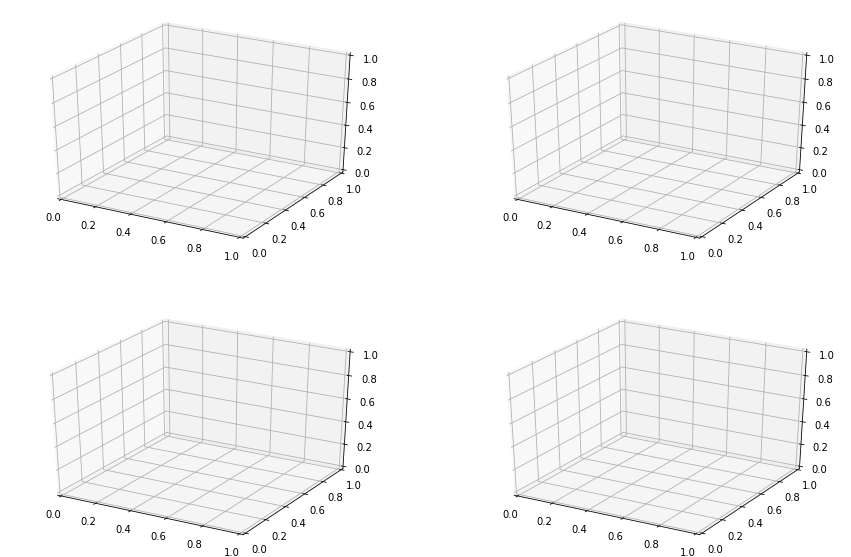

In [28]:
reporting.multi_plot(
    paths, 
    saving_path=SAVING_FOLDER,
    nb_subjects=len(subject_names_list),
    nb_voxels=nb_voxels,
    plot_name='', 
    new_masker=new_masker, 
    average_mask=average_mask,
    return_plot=True, 
    **kwargs
    )

## Semantic clustering

We cluster words based on their embedding, and apply the transformations learnt to the voxels of each subject independently.

In [ ]:
reporting.plot_semantic_clustering(
    data_words_filtered,
    path_to_data_template,
    average_mask,
    original_masker,
    new_masker,
    onsets_filtered,
    subject_names_list,
    subject_ids_list,
    data_name='{}_attention-head'.format(model_name),
    params=params,
    saving_folder=SAVING_FOLDER,
    n_neighbors_list=[3, 4, 5],
    min_samples_list=[ 20, 23,  25],
    min_cluster_size_list=[200, 300, 1200],
    tmp_folder=TMP_FOLDER, 
    model_name=model_name,
    aggregation_type='pca', # 'pca', 'layer', 'attention_head'
    return_plot=False,
    standardize_beta_maps=True,
    n_components_aggregation=100,
    **kwargs
    )

Number of neighbors:  3
Loading...


100%|██████████| 51/51 [01:35<00:00,  1.88s/it]


min_cluster_size:  200 min_samples:  20


100%|██████████| 51/51 [05:07<00:00,  6.04s/it]


min_cluster_size:  300 min_samples:  20


100%|██████████| 51/51 [07:02<00:00,  8.29s/it]


min_cluster_size:  1200 min_samples:  20


100%|██████████| 51/51 [08:58<00:00, 10.55s/it]


min_cluster_size:  200 min_samples:  23


100%|██████████| 51/51 [10:49<00:00, 12.73s/it]


min_cluster_size:  300 min_samples:  23


100%|██████████| 51/51 [13:00<00:00, 15.31s/it]


min_cluster_size:  1200 min_samples:  23


100%|██████████| 51/51 [15:15<00:00, 17.95s/it]


min_cluster_size:  200 min_samples:  25


100%|██████████| 51/51 [17:20<00:00, 20.39s/it]


min_cluster_size:  300 min_samples:  25


100%|██████████| 51/51 [19:21<00:00, 22.77s/it]


min_cluster_size:  1200 min_samples:  25


100%|██████████| 51/51 [21:09<00:00, 24.90s/it]


Number of neighbors:  4
Loading...


100%|██████████| 51/51 [10:09<00:00, 11.96s/it]


min_cluster_size:  200 min_samples:  20


100%|██████████| 51/51 [23:21<00:00, 27.47s/it]


min_cluster_size:  300 min_samples:  20


100%|██████████| 51/51 [25:25<00:00, 29.91s/it]


min_cluster_size:  1200 min_samples:  20


100%|██████████| 51/51 [27:32<00:00, 32.40s/it]


min_cluster_size:  200 min_samples:  23


100%|██████████| 51/51 [29:37<00:00, 34.84s/it]


min_cluster_size:  300 min_samples:  23


100%|██████████| 51/51 [32:19<00:00, 38.03s/it]


min_cluster_size:  1200 min_samples:  23


100%|██████████| 51/51 [35:03<00:00, 41.25s/it]


min_cluster_size:  200 min_samples:  25


 76%|███████▋  | 39/51 [27:19<08:28, 42.35s/it]

Have a look at scatter text plots that are saved in 'SAVING_FOLDER' (they are too heavy to display, ~10MB each).

In [ ]:
d = reporting.extract_clusters(labels_, onsets[mask])